# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import os
import seaborn as sns
from numpy import var, mean, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines
import numpy as np
import warnings
from scipy.stats import spearmanr
import scipy
from scipy.stats import ttest_ind

In [2]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## file paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### pioneer TF summary

In [6]:
def pioneer_tf_gene_correlation(
    adata,
    pioneer_tf,
    gene_list,
    genotype_colors,
    cell_type_list=None,
    reference_genotype="WT",
    genotype_key="genotype",
    cell_type_key="cell_type",
    save_path=None,
    layer="scVI_normalized",
    *args, **kwargs
):
    if pioneer_tf not in gene_list:
        gene_list.append(pioneer_tf)
    
    if cell_type is not None:
        plot_adata = adata[adata.obs[cell_type_key].isin(cell_type_list), gene_list]
    else:
        cell_type_list = "All"
        plot_adata = adata
        
    expression = pd.DataFrame(
        plot_adata.layers[layer],
        index=plot_adata.obs.index,
        columns=plot_adata.var_names
    )
    expression["genotype"] = plot_adata.obs[genotype_key]
    
    correlations = {}
    for genotype in expression.genotype.unique():
        correlations[genotype] = []
    
    for gene in gene_list:
        if gene != pioneer_tf:
            fig=plt.figure(figsize=(len(expression.genotype.unique())*4,4))
            ymin = expression[expression.genotype == reference_genotype][gene].min() - 0.5*expression[expression.genotype == reference_genotype][gene].min()
            ymax = expression[expression.genotype == reference_genotype][gene].max() + 0.5*expression[expression.genotype == reference_genotype][gene].max()
            xmin = expression[expression.genotype == reference_genotype][pioneer_tf].min() - 0.5*expression[expression.genotype == reference_genotype][pioneer_tf].min()
            xmax = expression[expression.genotype == reference_genotype][pioneer_tf].max() + 0.5*expression[expression.genotype == reference_genotype][pioneer_tf].max()
                
            for i,(genotype,color) in enumerate(genotype_colors.items()):
                r,p = spearmanr(expression[expression.genotype==genotype][pioneer_tf], expression[expression.genotype==genotype][gene])
                correlations[genotype].append(r)
                print(f"{pioneer_tf} -> {gene} in {genotype} for {cell_type_list} cells: R={round(r, 3)}, -log10(p)={round(-np.log10(p), 3)}")
                plt.subplot(1, len(expression.genotype.unique()), i+1)
                ax=sns.scatterplot(
                    x=expression[expression.genotype==genotype][pioneer_tf],
                    y=expression[expression.genotype==genotype][gene],
                    linewidth=0,
                    c=color,
                    *args, **kwargs
                )
                ax.set_xlim(xmin, xmax)
                ax.set_ylim(ymin, ymax)
                ax.set_xscale("log")
                ax.set_yscale("log")
                ax.set_title(genotype)
            plt.tight_layout()
            if save_path is not None:
                plt.savefig(f"{save_path}_{gene}.pdf", dpi=300)
            plt.show()
            print()
            
def pioneer_tf_vs_aire_correlation(adata, gene_list, pioneer_tf, cell_type, save_path=None):
    if pioneer_tf not in gene_list:
        gene_list.append(pioneer_tf)
    if "Aire" not in gene_list:
        gene_list.append("Aire")
    
    expression = pd.DataFrame(
        adata[(adata.obs.genotype == "WT") & (adata.obs.cell_type==cell_type), gene_list].layers["scVI_normalized"],
        index=adata[(adata.obs.genotype == "WT") & (adata.obs.cell_type==cell_type), gene_list].obs.index,
        columns=adata[(adata.obs.genotype == "WT") & (adata.obs.cell_type==cell_type), gene_list].var_names
    )
    corr = pd.DataFrame(spearmanr(expression)[0], columns=expression.columns, index=expression.columns)
    corr = corr[~corr.index.isin([pioneer_tf, "Aire"])]
    corr = corr[[pioneer_tf, "Aire"]]
    sns.displot(
        corr,
        kind="kde",
    )
    plt.xlabel("Spearman correlation coefficient")
    plt.ylabel(f"Density of {pioneer_tf} regulated genes")
    plt.show()
    if save_path is not None:
        plt.save_fig(save_path, bbox_inches="tight", dpi=300)

### gene expression heatmap

In [7]:
def heatmap_gene_expression(adata, gene_list, obs_key="cell_type", layer="scVI_normalized", save_path=None, *args, **kwargs):
    data = pd.DataFrame(
        adata[:, gene_list].layers[layer],
        index=adata.obs.index,
        columns=adata[:, gene_list].var_names
    )
    data[obs_key] = adata.obs[obs_key]
    data = data.groupby(obs_key).mean()
    cg = sns.clustermap(
        data,
        cmap="coolwarm",
        figsize=(0.5*len(gene_list), 0.5*len(adata.obs[obs_key].unique())),
        xticklabels=True,
        *args, **kwargs
    )
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.set_label_position("left")
    cg.ax_cbar.set_position([0.98, 0.45, 0.005, 0.3])
    if save_path is not None:
        plt.savefig(
            save_path,
            bbox_inches="tight",
            dpi=300
        )
    plt.show()

## import data

In [8]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
tabulaMurisData = sc.read(f"{processedDataPath}/M_cell/h5ad_files/tabula_muris_expression_filtered_genes.h5ad")
pbmc = sc.read(f"{processedDataPath}/M_cell/h5ad_files/PBMC_all_genes.h5ad")

# Pioneer TF list

In [9]:
pioneerTFs = list(adata.var_names[adata.var_names.str.startswith("Foxa")])
pioneerTFs = pioneerTFs + list(adata.var_names[adata.var_names.str.startswith("Gata")])
pioneerTFs = pioneerTFs + ["Pou5f1", "Sox2", "Klf4", "Spi1", "Cebpa", "Mef2c", "Tbx5", "Hand2", "Nkx2-5", "Ascl1", "Pou3f2", "Myt1l", "Hnf4a", "Hnf1a"]

# Cell type heatmap

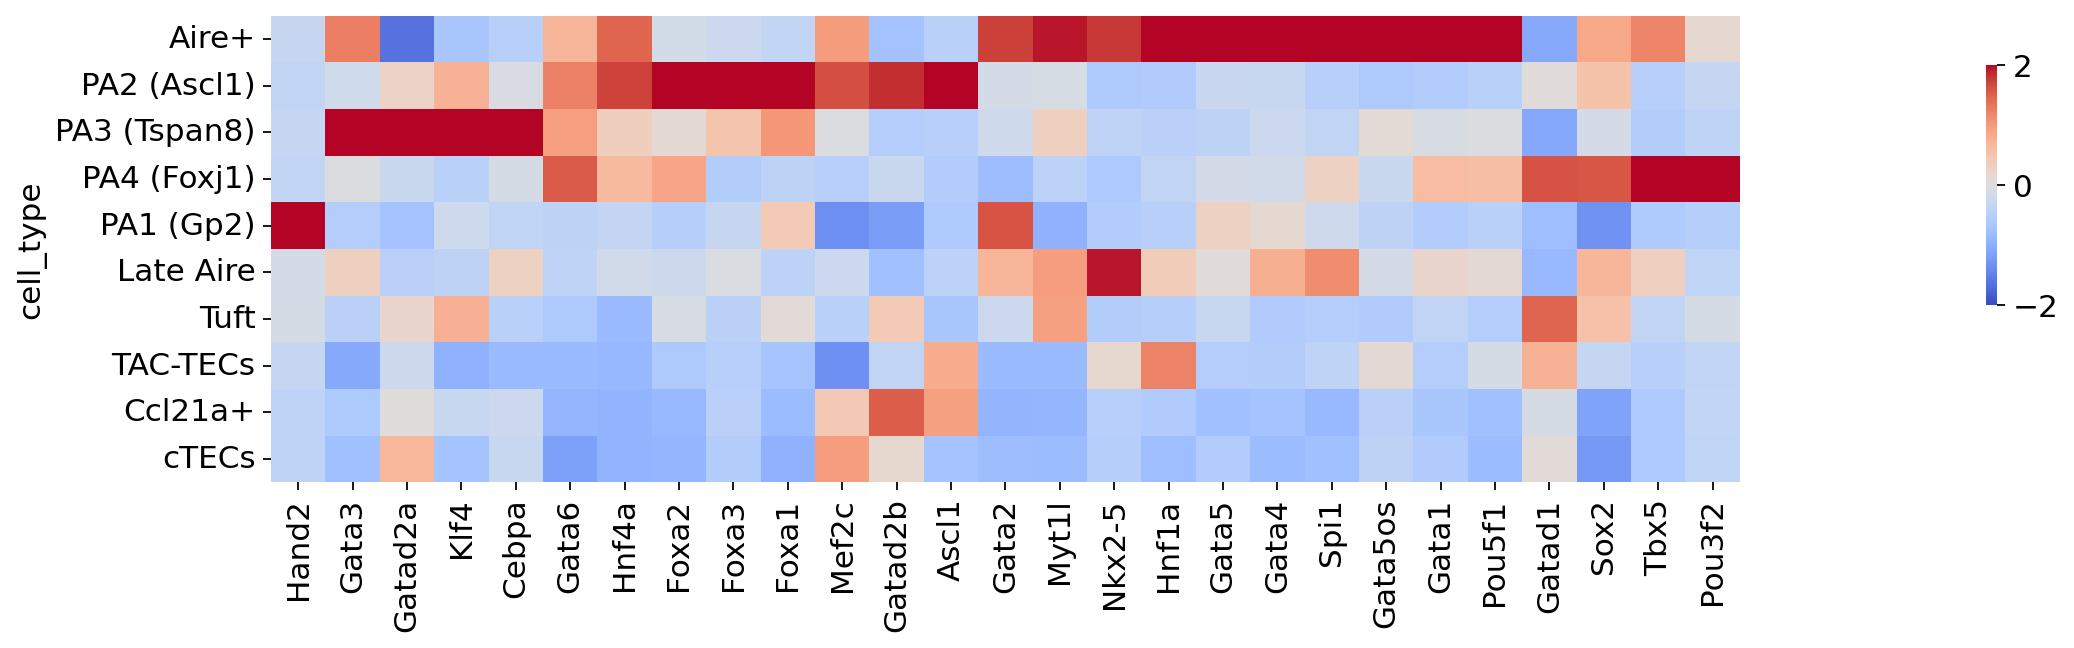

In [10]:
heatmap_gene_expression(
    adata[adata.obs.genotype == "WT"],
    gene_list=pioneerTFs,
    z_score=1,
    vmin=-2,
    vmax=2,
    save_path="../../analysis/Paper figs/2 (Aire KO)/2K_pioneer_TFs_WT_expression.pdf"
)

# Aire+ cluster expression across genotypes

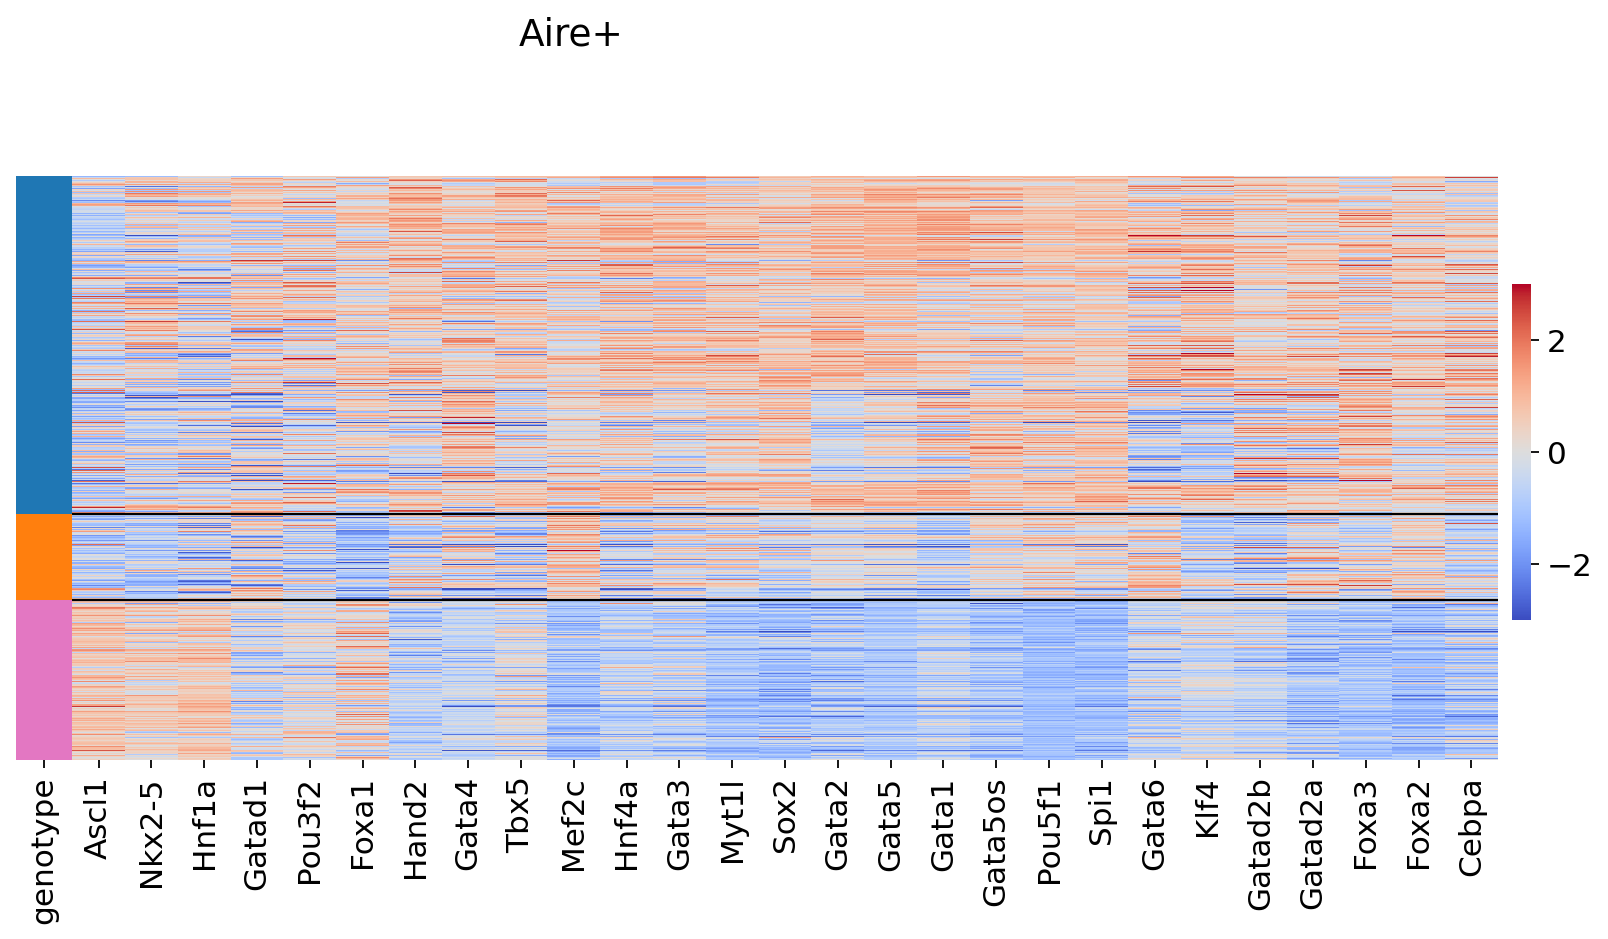

In [11]:
for cell_type in ["Aire+"]:
    plotData = np.log2(
        pd.DataFrame(
            adata[adata.obs.cell_type == cell_type, pioneerTFs].layers["scVI_normalized"],
            index=adata[adata.obs.cell_type == cell_type].obs.index,
            columns=adata[adata.obs.cell_type == cell_type, pioneerTFs].var_names
        )
    )

    plotData["genotype"] = adata.obs.genotype
   # plotData.genotype=pd.Categorical(plotData.genotype,categories=['WT', 'Aire_KO', 'Fezf2_KO'])
    plotData=plotData.sort_values(by=['genotype'], ascending=False)
    colors = plotData.genotype
    colors = colors.replace({"WT": "tab:blue", "Fezf2_KO": "tab:orange", "Aire_KO": "tab:pink"})
    del plotData["genotype"]

    cg=sns.clustermap(
        plotData,
        row_colors=colors,
        cmap="coolwarm",
        z_score=1,
        row_cluster=False,
        vmin=-3,
        vmax=3,
        yticklabels=False,
        figsize=(12,6),
    )
    numWT = len(colors[colors == "tab:blue"])-1
    numFezf2_KO = len(colors[colors == "tab:orange"])-1
    cg.ax_heatmap.axhline(y=numWT, color="black", linewidth=1)
    cg.ax_heatmap.axhline(y=numWT+numFezf2_KO, color="black", linewidth=1)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), rotation=0)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.set_label_position("left")
    cg.ax_cbar.set_position([0.99, 0.35, 0.01, 0.35])
    plt.suptitle(cell_type)
    plt.savefig("../../analysis/Paper figs/S3 (Aire KO)/S3D_pioneer_TFs_Aire+_genotype_expression.pdf", dpi=300, bbox_inches="tight")
    plt.show()

# Bulk Aire-reg pioneer TFs

In [12]:
aireRegGenes = pd.read_csv("../../Aire_pos_vs_Aire_KO.csv", index_col=0)
aireRegPioneerTFs = aireRegGenes[aireRegGenes["Gene Symbol"].isin(pioneerTFs)]
aireRegPioneerTFs.to_csv("../../analysis/aire_reg_pioneer_TFs_from_bulk.csv")
aireRegPioneerTFs["LFC"] = np.log2(aireRegPioneerTFs["Fold Change"])
aireRegPioneerTFs

/tmp/ipykernel_826310/529445540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aireRegPioneerTFs["LFC"] = np.log2(aireRegPioneerTFs["Fold Change"])


,Gene Symbol,Aire_pos_TEC (mean counts),Aire_ko_TEC (mean counts),Fold Change,FDR (BH),LFC
Ensembl ID,,,,,,
ENSMUSG00000024406,Pou5f1,395.813383,17.586233,0.044431,4.025250e-44,-4.492302
ENSMUSG00000015053,Gata2,175.025162,9.669433,0.055246,4.714830e-22,-4.177987
ENSMUSG00000061911,Myt1l,242.825110,14.003673,0.057670,1.132840e-29,-4.116040
ENSMUSG00000015579,Nkx2-5,11.005004,1.232833,0.112025,4.871566e-03,-3.158110
ENSMUSG00000015627,Gata5,138.161286,19.435483,0.140672,1.633380e-14,-2.829589
ENSMUSG00000005583,Mef2c,106.496861,28.565792,0.268231,4.176430e-08,-1.898450
ENSMUSG00000017950,Hnf4a,550.399546,157.004615,0.285256,4.450450e-14,-1.809672
ENSMUSG00000074637,Sox2,92.564888,36.963746,0.399328,4.557960e-04,-1.324354
ENSMUSG00000037025,Foxa2,152.087883,61.118005,0.401860,4.155230e-05,-1.315236
